## Pré-processamento

Na fase de criação do dataset uma parte do pré-processamento já foi feita, foi o passo de transformar todas as letras em minúsculas. Na fase atual, inicialmente, tivemos a ideia de remover as stopwords que englobam conectivos como conjunções (e, como, ou, ...). Caso fossem removidas os versos poderiam ficar sem muito significado.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

In [4]:
# Importação dos dados
dataset = pd.read_csv('musics.csv', encoding = "utf-8")
dataset

,artist,music,track
0,Djavan,"valei-me, deus!\né o fim do nosso amor\nperdoa...",Flor de Lis
1,Gilberto Gil,"aiaiá, kiriê \nkiriê, iaiá \n\na refavela \nre...",Refavela
2,Caetano Veloso,eu sou o vento que lança a areia do saara\nsob...,Reconvexo - Ao Vivo
3,Cássia Eller,é uma índia com colar\na tarde linda que não q...,Relicário - Ao Vivo
4,Elis Regina,não quero lhe falar meu grande amor \ndas cois...,Como Nossos Pais
5,Geraldo Azevedo,se você vier pro que der e vier comigo\neu lhe...,Dia Branco - Ao Vivo | Bonus Track
6,Adriana Calcanhotto,rasgue as minhas cartas\ne não me procure mais...,Devolva-Me (Ao Vivo)
7,João Gilberto,vai minha tristeza e diz a ela que\nsem ela nã...,Chega de Saudade
8,Chico Buarque,"não se afobe, não\nque nada é pra já \no amor ...",Futuros Amantes
9,Ney Matogrosso,tudo de bom que você me fizer\nfaz minha rima ...,Sorte


## Wordcloud

Visualização das palavras que mais se repetem do dataset importado. É claro que conjunções e pronomes são mais utilizados, talvez até poluam o dataset, mas sem estas palavras o sentido dos versos/frases estará comprometido e por isso não serão removidas.

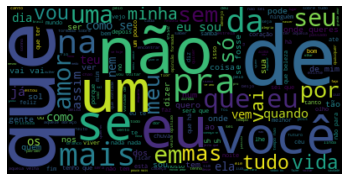

In [17]:
musics = ''.join(dataset['music'])
wordcloud = WordCloud(max_font_size=100, max_words=200, background_color="black").generate(musics)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()